In [61]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common

## Configuraciones

In [62]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib


pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [63]:
TAM_TITULO = 35
TAM_ETIQUETA = 30

### Configuraciones de librerias

### Funciones auxiliares

In [64]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [65]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [66]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en precio:

In [67]:
n_tipodepropiedad_nan = df["tipodepropiedad"].isnull().sum()
n_tipodepropiedad_nan

46

## ¿Cuáles son las provincias con propiedades más caras y cuáles con las más baratas?

In [68]:
provincia_precio = df.groupby('provincia')['precio'].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18092c38be0>)

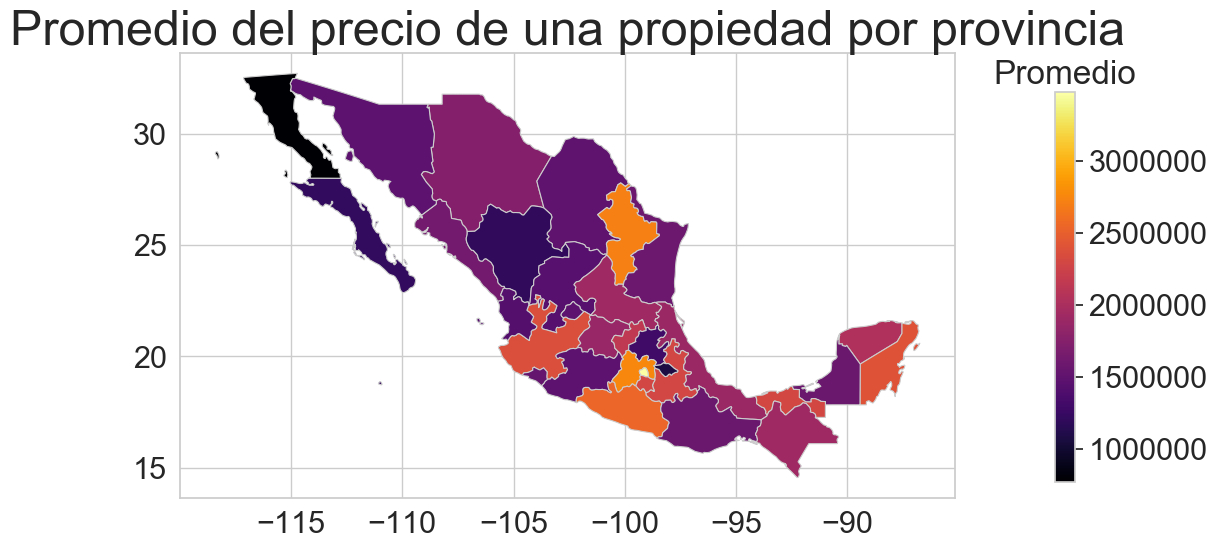

In [69]:
common.crear_mapa(provincia_precio, "precio", provincia_precio.min(), provincia_precio.max(), "Promedio del precio de una propiedad por provincia", "Promedio", "inferno")

### Top 5 provincias con viviendas más caras

In [70]:
provincia_precio_df = provincia_precio.to_frame()
provincia_precio_df.rename(columns = {'precio': 'Precio promedio de propiedad'}, inplace=True)

In [71]:
provincias_caras = provincia_precio_df.nlargest(5, "Precio promedio de propiedad")
provincias_caras

,Precio promedio de propiedad
provincia,
Distrito Federal,"3,471,705.00"
Edo. de México,"2,762,465.00"
Nuevo León,"2,717,757.75"
Guerrero,"2,548,741.75"
Quintana Roo,"2,402,967.00"


### Top 5 estados con viviendas más baratas

In [72]:
provincias_baratas = provincia_precio_df.nsmallest(5, "Precio promedio de propiedad")
provincias_baratas

,Precio promedio de propiedad
provincia,
Baja California Norte,"767,441.75"
Tlaxcala,"1,080,993.38"
Durango,"1,210,389.00"
Baja California Sur,"1,216,452.88"
Hidalgo,"1,305,550.50"


## Promedios de las características de las propiedades por provincia

In [73]:
categorias = ["habitaciones", "banos", "garages"]

### Promedios de las caracteristicas de las provincias con propiedades más caras:

In [74]:
provincias_caras_df = df[df["provincia"].isin(list(provincias_caras.index))]
provincias_caras_df = provincias_caras_df.groupby("provincia")[categorias].mean()
provincias_caras_df

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.74,1.99,1.42
Edo. de México,2.97,2.08,1.66
Guerrero,2.82,2.29,1.33
Nuevo León,2.94,2.31,1.53
Quintana Roo,2.85,2.34,1.58


<Figure size 640x480 with 0 Axes>

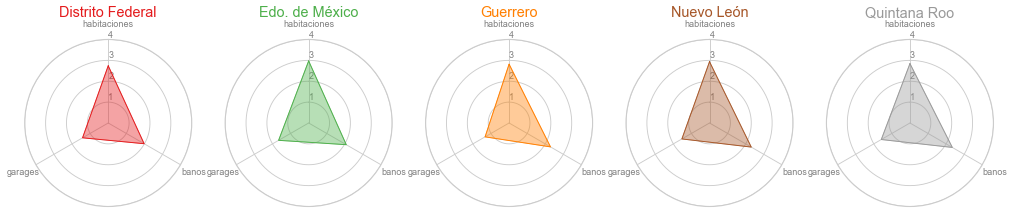

<Figure size 640x480 with 0 Axes>

In [75]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
common.crear_radares_alineados(provincias_caras_df.reset_index(), 1, 5, "Set1")

### Promedios de las caracteristicas de las provincias con propiedades más baratas:

In [76]:
provincias_baratas_df = df[df["provincia"].isin(list(provincias_baratas.index))]
provincias_baratas_df = provincias_baratas_df.groupby("provincia")[categorias].mean()
provincias_baratas_df

,habitaciones,banos,garages
provincia,,,
Baja California Norte,2.58,1.37,1.61
Baja California Sur,2.63,1.61,1.68
Durango,3.05,1.95,1.47
Hidalgo,2.88,1.81,1.48
Tlaxcala,2.83,1.55,1.38


<Figure size 640x480 with 0 Axes>

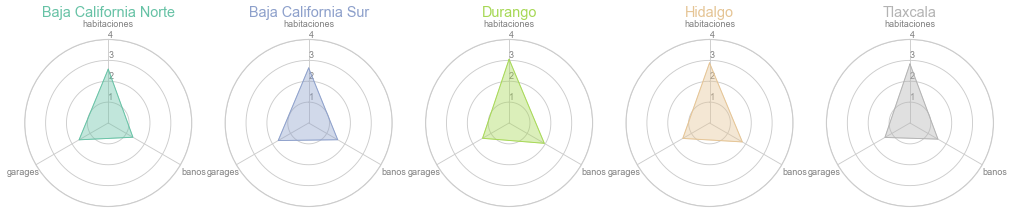

<Figure size 640x480 with 0 Axes>

In [77]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
common.crear_radares_alineados(provincias_baratas_df.reset_index(), 1, 5, "Set2")